# XGBoost Models | with feature selection and normalized data

**XGBRegressor**

Josie Donnelly

*Last updated 11.29.22*

In [1]:
import numpy as np
import pandas as pd
#import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout


## Preprocessing

In [6]:
dim = 11

# load merged dataset
path = '../../DSI_bgcArgoProject/data/'
#file = 'float_sat_normalized_depth.csv'

#path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = f'final_norm_set_{dim}.csv'
df_orig = pd.read_csv(path + file)
df_orig


,float,cycleNumber,latitude,longitude,date_doy_rad,sat_chl_month,sat_sst_month,sat_par_month,sat_pic_month,sat_aph_443_month,...,norm_2,norm_3,norm_4,norm_5,norm_6,norm_7,norm_8,norm_9,norm_10,cluster_val
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,39.556000,0.000184,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,0
1,1902303,2,49.096,-14.617,2.167505,0.782180,12.466026,42.348000,0.000188,0.0405,...,1.369272,0.695493,0.245930,0.127053,0.080711,0.091777,0.035233,0.028154,0.017669,0
2,1902303,3,48.914,-14.606,2.184708,0.458020,12.424099,44.795998,0.000144,0.0358,...,1.060779,0.952159,0.332255,0.278597,0.099195,0.064459,0.037555,0.023375,0.016029,0
3,1902303,4,48.794,-14.689,2.201910,0.378064,12.374519,43.792000,0.000098,0.0353,...,1.514563,1.419672,0.883025,0.225947,0.090078,0.053342,0.037827,0.026166,0.024358,0
4,1902303,5,48.719,-14.795,2.219113,0.411479,12.204494,42.143997,0.000176,0.0244,...,1.046541,1.035285,0.103117,0.051044,0.025997,0.034813,0.031769,0.022268,0.013801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42333,7901001,10,17.103,-24.442,1.376194,0.327877,21.746379,51.337997,0.000010,0.0183,...,0.285977,0.206919,0.187004,0.133988,0.075797,0.060847,0.041803,0.008409,0.007097,2
42334,7901001,11,17.131,-24.170,1.410599,0.390988,21.762587,49.129997,0.000010,0.0213,...,0.186414,0.169653,0.141454,0.085831,0.041898,0.045638,0.042897,0.010001,0.002762,2
42335,7901001,12,16.968,-23.922,1.445004,0.208484,21.850749,50.998001,0.000042,0.0128,...,0.105721,0.269710,0.198070,0.210563,0.071214,0.046819,0.020902,0.008526,0.003394,2
42336,7901001,13,16.803,-23.778,1.479408,0.162081,21.975307,50.112000,0.000010,0.0106,...,0.082853,0.150223,0.252729,0.184985,0.089319,0.055683,0.029777,0.008856,0.002808,2


In [7]:
' '.join(list(df_orig.columns))

'float cycleNumber latitude longitude date_doy_rad sat_chl_month sat_sst_month sat_par_month sat_pic_month sat_aph_443_month depth_bin_0 depth_bin_1 depth_bin_2 depth_bin_3 depth_bin_4 depth_bin_5 depth_bin_6 depth_bin_7 depth_bin_8 depth_bin_9 depth_bin_10 depth_bin_11 depth_bin_12 depth_bin_13 depth_bin_14 depth_bin_15 depth_bin_16 depth_bin_17 depth_bin_18 depth_bin_19 depth_bin_20 depth_bin_21 depth_bin_22 depth_bin_23 depth_bin_24 depth_bin_25 depth_bin_26 depth_bin_27 depth_bin_28 depth_bin_29 depth_bin_30 depth_bin_31 depth_bin_32 depth_bin_33 depth_bin_34 depth_bin_35 depth_bin_36 depth_bin_37 depth_bin_38 depth_bin_39 depth_bin_40 depth_bin_41 depth_bin_42 depth_bin_43 depth_bin_44 depth_bin_45 depth_bin_46 depth_bin_47 depth_bin_48 depth_bin_49 depth_bin_50 depth_bin_51 depth_bin_52 depth_bin_53 depth_bin_54 depth_bin_55 depth_bin_56 depth_bin_57 depth_bin_58 depth_bin_59 depth_bin_60 depth_bin_61 depth_bin_62 depth_bin_63 depth_bin_64 depth_bin_65 depth_bin_66 depth_bin_67 d

In [8]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month'] + [f'norm_{i}' for i in range(dim)] + ['train']]
df = df.rename(columns={'cycleNumber': 'cycle', 'date_doy_rad': 'day_of_year_rad'})
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

print(list(df.columns))


['float', 'cycle', 'latitude', 'longitude', 'day_of_year_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month', 'norm_0', 'norm_1', 'norm_2', 'norm_3', 'norm_4', 'norm_5', 'norm_6', 'norm_7', 'norm_8', 'norm_9', 'norm_10', 'train']


In [9]:
df.isna().sum()


float                0
cycle                0
latitude             0
longitude            0
day_of_year_rad      0
sat_chl_month        0
sat_sst_month        0
sat_pic_month        0
sat_par_month        0
sat_aph_443_month    0
norm_0               0
norm_1               0
norm_2               0
norm_3               0
norm_4               0
norm_5               0
norm_6               0
norm_7               0
norm_8               0
norm_9               0
norm_10              0
train                0
dtype: int64

In [10]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

In [11]:
chla_vals = []
norm_vals = []
for row in range(df.shape[0]):
    chla_vals += list(df.loc[row,[f'norm_{i}' for i in range(dim)]])
    norm_vals += [i/(dim-1) for i in range(dim)]
print(f'Length chla_vals: {len(chla_vals)}')


Length chla_vals: 465718


In [12]:
# pivot table longer so each normalized CHLA value is a true CHLA value for that observation
df = df.append([df]*(dim-1)).sort_values(by=['float', 'cycle'], axis=0, ascending=True, ignore_index=True)
print(df.shape[0])
df


465718


/var/folders/2s/dqvyr8r92_v2nfvgky0vvxbc0000gn/T/ipykernel_86809/3845562706.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([df]*(dim-1)).sort_values(by=['float', 'cycle'], axis=0, ascending=True, ignore_index=True)


,float,cycle,latitude,longitude,day_of_year_rad,sat_chl_month,sat_sst_month,sat_pic_month,sat_par_month,sat_aph_443_month,...,norm_2,norm_3,norm_4,norm_5,norm_6,norm_7,norm_8,norm_9,norm_10,train
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,1
1,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,1
2,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,1
3,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,1
4,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,...,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,0.029838,0.027205,0.017237,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465713,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,...,0.086245,0.142229,0.215448,0.166912,0.062631,0.030462,0.022205,0.009474,0.003290,1
465714,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,...,0.086245,0.142229,0.215448,0.166912,0.062631,0.030462,0.022205,0.009474,0.003290,1
465715,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,...,0.086245,0.142229,0.215448,0.166912,0.062631,0.030462,0.022205,0.009474,0.003290,1
465716,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,...,0.086245,0.142229,0.215448,0.166912,0.062631,0.030462,0.022205,0.009474,0.003290,1


In [13]:
df = df.drop(columns=[f'norm_{i}' for i in range(dim)])
df['norm'] = norm_vals
df['CHLA'] = chla_vals
df


,float,cycle,latitude,longitude,day_of_year_rad,sat_chl_month,sat_sst_month,sat_pic_month,sat_par_month,sat_aph_443_month,train,norm,CHLA
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,1,0.0,0.704058
1,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,1,0.1,0.670175
2,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,1,0.2,0.886368
3,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,1,0.3,0.774768
4,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,1,0.4,0.367744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
465713,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,1,0.6,0.062631
465714,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,1,0.7,0.030462
465715,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,1,0.8,0.022205
465716,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,1,0.9,0.009474


In [14]:
# ensure the rows of the dataframe are unique between train and test
df.shape[0] == df.drop(columns='train').drop_duplicates().shape[0]


True

In [28]:
# train-test-split
train_df = df[df['train']==1].reset_index(drop=True).drop(columns='train')
test_df = df[df['train']==0].reset_index(drop=True).drop(columns='train')


In [29]:
print(f'Number of train observations: {train_df.shape[0]}')
print(f'Number of test observations: {test_df.shape[0]}')

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(train_df['float']), list(train_df['cycle']))])
test_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(test_df['float']), list(test_df['cycle']))])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 374253
Number of test observations: 91465

Number of unique train float-cycles: 34023
Number of unique test float-cycles: 8315
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [53]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(data_df, features):
    id_df = data_df[['float', 'cycle', 'norm', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    data_df = data_df[features]
    
    return data_df, id_df


In [54]:
def standardize(train_data_df, test_data_df, return_scaler=False):
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    if return_scaler:
        return X_train, X_test, y_train, y_test, ss
    return X_train, X_test, y_train, y_test
          

In [68]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test, xgb_train, xgb_test):
    X_train['xgb'] = xgb_train
    X_test['xgb'] = xgb_test
    model.fit(X_train, y_train, batch_size = 256, epochs = 12, verbose=1)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    return train_preds, test_preds

In [69]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict_xgbr(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds

In [70]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(y_train, train_preds, y_test, test_preds, plt_n_cols=5):  
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title('Predicted vs. True CHLA Values', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend(loc='lower right')
    

In [71]:
def createNueralNetwork():
    # create ANN model
    model = Sequential()

    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(units=10, input_dim=10, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(units=20, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Train one XGB model over all depths

In [72]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['float', 'cycle', 'norm', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['float', 'cycle', 'norm', 'true_CHLA', 'pred_CHLA'])

train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month', 'norm', 'CHLA']


In [73]:
len(train_features)

10

In [66]:
# fit a Mixed model that uses XGBR as a feature for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(6,6))
plt.suptitle('Predicted vs. True CHLA from Nueral Network Regressor by Depth Bin\n\n', fontsize='xx-large')
model_path =  '../nueral_net_models/'

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')
    
    # obtain train and test data for this bin
    train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features, depth_bin=depth_idx)
    test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features, depth_bin=depth_idx)
    #train_data_df['xgb'] = xgb_feature_train
    #test_data_df['xgb'] = xgb_feature_test
    train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
    test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])
    
    print(train_data_df.shape)
    print(test_data_df.shape)
    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)
    print(X_train.shape)
    print(X_test.shape)
    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    

    xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    xgb_feature_train, xgb_feature_test = fit_predict_xgbr(xgbr, X_train, y_train, X_test, y_test)

    # train, predict, and get scores for XGBoosting regressor
    nnr = createNueralNetwork() #XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(nnr, X_train, y_train, X_test, y_test, xgb_feature_train, xgb_feature_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, plt_n_cols=5)
    
    # add scores and predictions to respective dataframes
    results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    train_predictions_for_depth_df['pred_CHLA'] = train_preds
    train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
    test_predictions_for_depth_df['pred_CHLA'] = test_preds
    test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])
    
    # save the model for this depth bin
    model_file = 'nueral_net_model_depth_bin_{depth_idx}'
    try:
        pickle.dump(nnr, open(model_path + model_file, 'wb'))
    except:
        os.mkdir(model_path)
        pickle.dump(nnr, open(model_path + model_file, 'wb'))
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()

NameError: name 'bins' is not defined

<Figure size 432x432 with 0 Axes>

Neural Net regressor trained over the entire euphotic zone
	Num train samples: 374253  |  Num test samples: 91465
Epoch 1/12
   1/1462 [..............................] - ETA: 6:50 - loss: 0.3128

2022-11-30 15:02:34.100277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1462/1462 [==============================] - 11s 7ms/step - loss: 0.0534
Epoch 2/12
1462/1462 [==============================] - 10s 7ms/step - loss: 0.0297
Epoch 3/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0293
Epoch 4/12
1462/1462 [==============================] - 8s 6ms/step - loss: 0.0289
Epoch 5/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0274
Epoch 6/12
1462/1462 [==============================] - 8s 6ms/step - loss: 0.0249
Epoch 7/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0235
Epoch 8/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0230
Epoch 9/12
1462/1462 [==============================] - 8s 6ms/step - loss: 0.0227
Epoch 10/12
1462/1462 [==============================] - 8s 6ms/step - loss: 0.0224
Epoch 11/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0223
Epoch 12/12
1462/1462 [==============================] - 9s 6ms/step - loss: 0.0221


2022-11-30 15:04:22.162822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


	Train MSE: 0.0283  |  Train r2: 0.8693
	Test MSE: 0.0774   |  Test r2: 0.6147
INFO:tensorflow:Assets written to: ram://ddc48ed8-c387-49ad-ac88-23cc18a34ea2/assets



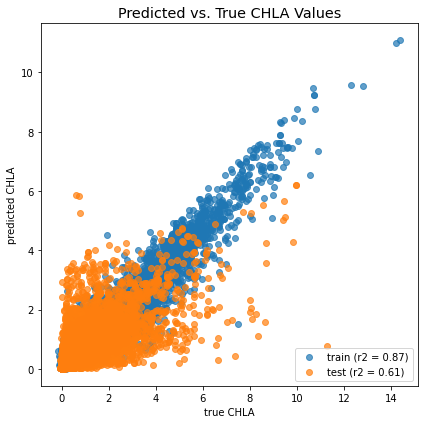

In [74]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(6,6))

if verbose > 0:
    print('Neural Net regressor trained over the entire euphotic zone')

# obtain train and test data for this bin
train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features)
test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features)

# standardize features based on training data
X_train, X_test, y_train, y_test, ss = standardize(train_data_df, test_data_df, return_scaler=True)

if verbose > 0:
    print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
    print(f'Num test samples: {X_test.shape[0]}')

# train, predict, and get scores for XGBoosting regressor
xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.7)     # grow_policy = 'depthwise' or 'lossguide'    # grow_policy = 'depthwise' or 'lossguide'
xgb_feature_train, xgb_feature_test = fit_predict_xgbr(xgbr, X_train, y_train, X_test, y_test)

# train, predict, and get scores for XGBoosting regressor
nnr = createNueralNetwork() #XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
train_preds, test_preds = fit_predict(nnr, X_train, y_train, X_test, y_test, xgb_feature_train, xgb_feature_test)
    

if verbose > 0: 
    print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
    print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
    print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
    print(f'Test r2: {r2_score(y_test, test_preds):.4f}')

# plot predictions vs. true values
plot(y_train, train_preds, y_test, test_preds)

# add scores and predictions to respective dataframes
results_df.loc[results_df.shape[0]] = [train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
train_predictions_for_depth_df['pred_CHLA'] = train_preds
train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
test_predictions_for_depth_df['pred_CHLA'] = test_preds
test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])

# save the model
model_path = path + f'nnr_single_model_{dim}/'
model_file = f'nnr_model_std_inputs_{dim}.model'
try:
    pickle.dump(nnr, open(model_path + model_file, 'wb'))
except:
    os.mkdir(model_path)
    pickle.dump(nnr, open(model_path + model_file, 'wb'))

if verbose > 0:
    print()
        
plt.tight_layout()
plt.show()

In [75]:
# display the dataframe of results
results_df


,num_observations,train_mse,train_r2,test_mse,test_r2
0,465718.0,0.028346,0.869281,0.077449,0.61472


0.0 | Test r2 : 0.6203 | Train r2: 0.8805
0.1 | Test r2 : 0.6224 | Train r2: 0.8937
0.2 | Test r2 : 0.5826 | Train r2: 0.8674
0.3 | Test r2 : 0.4810 | Train r2: 0.8140
0.4 | Test r2 : 0.3913 | Train r2: 0.7462
0.5 | Test r2 : 0.2441 | Train r2: 0.6936
0.6 | Test r2 : 0.1878 | Train r2: 0.6052
0.7 | Test r2 : 0.0742 | Train r2: 0.5681
0.8 | Test r2 : -0.0390 | Train r2: 0.3643
0.9 | Test r2 : -0.5401 | Train r2: -0.0149
1.0 | Test r2 : -1.1077 | Train r2: -0.5577


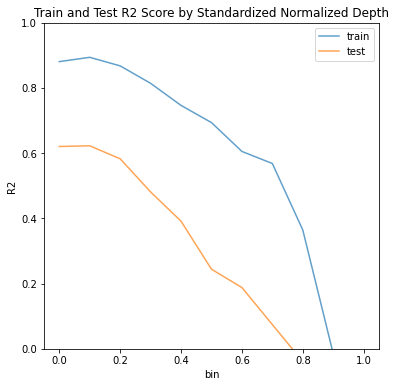

In [76]:
# find R^2 values for various normalized depth bins
bins = np.unique(df['norm'])
test_r2s = []
train_r2s = []
for b in bins:
    tmp_df = test_predictions_df[(test_predictions_df['norm'] == b)]
    r2 = r2_score(tmp_df["true_CHLA"], tmp_df["pred_CHLA"])
    print(f'{b} | Test r2 : {r2:.4f}', end=' | ')
    test_r2s.append(r2)
    tmp_df = train_predictions_df[(train_predictions_df['norm'] == b)]
    r2 = r2_score(tmp_df["true_CHLA"], tmp_df["pred_CHLA"])
    print(f'Train r2: {r2:.4f}')
    train_r2s.append(r2)
    
plt.figure(figsize=(6,6))
plt.title('Train and Test R2 Score by Standardized Normalized Depth')
plt.plot(bins, train_r2s, alpha=0.7, label='train')
plt.plot(bins, test_r2s, alpha=0.7, label='test')
plt.xlabel('bin')
plt.ylabel('R2')
plt.ylim(bottom=0, top=1)
plt.legend(loc='best')
plt.show()
    

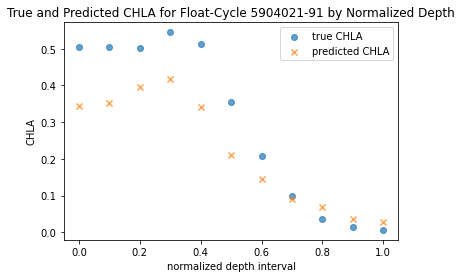

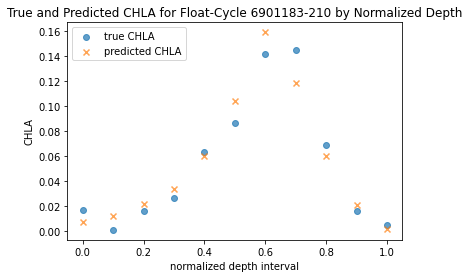

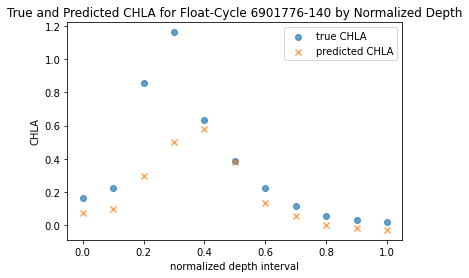

In [21]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(6,4))
    plt.scatter(tmp_df['norm'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['norm'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [22]:
# pivot train predictions tables shorter
true_chla_train = np.array(train_predictions_df['true_CHLA'])
true_chla_train = true_chla_train.reshape(int(len(true_chla_train)/dim), dim)
train_true_chla_df = pd.DataFrame(data=true_chla_train, columns=[f'true_CHLA_{i}' for i in range(dim)])

pred_chla_train = np.array(train_predictions_df['pred_CHLA'])
pred_chla_train = pred_chla_train.reshape(int(len(pred_chla_train)/dim), dim)
train_pred_chla_df = pd.DataFrame(data=pred_chla_train, columns=[f'pred_CHLA_{i}' for i in range(dim)])

train_preds_df = train_predictions_df.drop(columns={'norm', 'true_CHLA', 'pred_CHLA'}).drop_duplicates().reset_index(drop=True)
train_preds_df = train_preds_df.reset_index().join(other=[train_true_chla_df, train_pred_chla_df]).drop(columns='index')
train_preds_df['train'] = 1
train_preds_df


,float,cycle,true_CHLA_0,true_CHLA_1,true_CHLA_2,true_CHLA_3,true_CHLA_4,true_CHLA_5,true_CHLA_6,true_CHLA_7,...,pred_CHLA_2,pred_CHLA_3,pred_CHLA_4,pred_CHLA_5,pred_CHLA_6,pred_CHLA_7,pred_CHLA_8,pred_CHLA_9,pred_CHLA_10,train
0,1902303,1,0.704058,0.670175,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,...,1.164417,0.788061,0.535127,0.405980,0.190471,0.125002,0.068870,0.047077,0.048443,1
1,1902303,2,0.691814,0.768679,1.369272,0.695493,0.245930,0.127053,0.080711,0.091777,...,1.152950,0.802887,0.570533,0.398184,0.188665,0.117601,0.014602,-0.006120,-0.002279,1
2,1902303,3,1.063866,0.967499,1.060779,0.952159,0.332255,0.278597,0.099195,0.064459,...,1.061498,1.034546,0.659979,0.373401,0.232960,0.139202,0.082055,0.065870,0.067236,1
3,1902303,4,1.432731,1.406462,1.514563,1.419672,0.883025,0.225947,0.090078,0.053342,...,1.274306,1.159261,0.781489,0.325216,0.169217,0.113068,0.051361,0.033891,0.028010,1
4,1902303,6,0.809564,0.787566,0.826573,0.824540,0.148340,0.077793,0.057819,0.039432,...,0.884221,0.898036,0.541916,0.303464,0.162877,0.083011,0.025357,0.003884,-0.001929,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34018,7901001,7,0.292000,0.292030,0.291609,0.293650,0.247718,0.162901,0.118098,0.102299,...,0.458561,0.327983,0.245035,0.152403,0.103549,0.051820,0.026121,0.011017,0.002902,1
34019,7901001,8,0.306600,0.306586,0.306600,0.309231,0.270187,0.193425,0.112188,0.072639,...,0.446969,0.342647,0.218442,0.165529,0.110331,0.051820,0.028932,0.013828,0.003238,1
34020,7901001,9,0.164250,0.164250,0.164251,0.164259,0.164039,0.163073,0.119967,0.067650,...,0.410090,0.259907,0.160673,0.117754,0.100999,0.052700,0.025936,0.010832,0.002718,1
34021,7901001,11,0.186150,0.186078,0.186414,0.169653,0.141454,0.085831,0.041898,0.045638,...,0.443515,0.455967,0.215984,0.165288,0.110348,0.069880,0.027490,0.004870,-0.001486,1


In [23]:
# pivot test predictions tables shorter
true_chla_test = np.array(test_predictions_df['true_CHLA'])
true_chla_test = true_chla_test.reshape(int(len(true_chla_test)/dim), dim)
test_true_chla_df = pd.DataFrame(data=true_chla_test, columns=[f'true_CHLA_{i}' for i in range(dim)])

pred_chla_test = np.array(test_predictions_df['pred_CHLA'])
pred_chla_test = pred_chla_test.reshape(int(len(pred_chla_test)/dim), dim)
test_pred_chla_df = pd.DataFrame(data=pred_chla_test, columns=[f'pred_CHLA_{i}' for i in range(dim)])

test_preds_df = test_predictions_df.drop(columns={'norm', 'true_CHLA', 'pred_CHLA'}).drop_duplicates().reset_index(drop=True)
test_preds_df = test_preds_df.reset_index().join(other=[test_true_chla_df, test_pred_chla_df]).drop(columns='index')
test_preds_df['train'] = 0
test_preds_df


,float,cycle,true_CHLA_0,true_CHLA_1,true_CHLA_2,true_CHLA_3,true_CHLA_4,true_CHLA_5,true_CHLA_6,true_CHLA_7,...,pred_CHLA_2,pred_CHLA_3,pred_CHLA_4,pred_CHLA_5,pred_CHLA_6,pred_CHLA_7,pred_CHLA_8,pred_CHLA_9,pred_CHLA_10,train
0,1902303,5,1.008395,1.047154,1.046541,1.035285,0.103117,0.051044,0.025997,0.034813,...,1.165930,0.933245,0.576858,0.364941,0.245397,0.154054,0.124282,0.098316,0.092503,0
1,1902303,9,1.349276,1.850947,1.901479,1.744434,1.476100,1.045870,0.508370,0.130249,...,1.146450,1.070583,0.685088,0.391221,0.295203,0.210102,0.157060,0.135587,0.132249,0
2,1902303,10,1.452846,1.487239,1.477649,0.836737,0.618746,0.516823,0.396084,0.167500,...,1.002109,0.878216,0.540747,0.287738,0.177063,0.107389,0.051426,0.038608,0.035271,0
3,1902303,25,2.601795,1.883820,0.834031,0.209424,0.145500,0.112419,0.103308,0.094152,...,1.020995,0.632911,0.347671,0.224427,0.118900,0.053033,0.002827,-0.019571,-0.025031,0
4,1902303,34,1.501445,0.960222,0.620863,0.443711,0.247546,0.136229,0.091572,0.052002,...,0.818916,0.791293,0.349712,0.190201,0.084673,0.010727,-0.010335,-0.025508,-0.031321,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8310,7900589,39,0.503700,0.503807,0.500617,0.510871,0.432052,0.193971,0.019336,0.022526,...,0.732436,0.651227,0.628489,0.567143,0.217903,0.049571,0.028057,0.002853,0.000604,0
8311,7901001,2,0.281050,0.281051,0.281042,0.281073,0.281929,0.275436,0.147969,0.083070,...,0.321224,0.296707,0.222643,0.168110,0.131482,0.062122,0.025497,0.005277,-0.001079,0
8312,7901001,10,0.284700,0.284245,0.285977,0.206919,0.187004,0.133988,0.075797,0.060847,...,0.327803,0.351722,0.257269,0.167195,0.111454,0.062248,0.024748,0.004611,-0.001746,0
8313,7901001,12,0.065700,0.064070,0.105721,0.269710,0.198070,0.210563,0.071214,0.046819,...,0.228858,0.331955,0.353158,0.208148,0.142006,0.067751,0.026688,0.004343,-0.003468,0


In [24]:
# concatinate results
predictions_df = pd.concat([train_preds_df, test_preds_df]).reset_index(drop=True)
predictions_df


,float,cycle,true_CHLA_0,true_CHLA_1,true_CHLA_2,true_CHLA_3,true_CHLA_4,true_CHLA_5,true_CHLA_6,true_CHLA_7,...,pred_CHLA_2,pred_CHLA_3,pred_CHLA_4,pred_CHLA_5,pred_CHLA_6,pred_CHLA_7,pred_CHLA_8,pred_CHLA_9,pred_CHLA_10,train
0,1902303,1,0.704058,0.670175,0.886368,0.774768,0.367744,0.176219,0.094204,0.064108,...,1.164417,0.788061,0.535127,0.405980,0.190471,0.125002,0.068870,0.047077,0.048443,1
1,1902303,2,0.691814,0.768679,1.369272,0.695493,0.245930,0.127053,0.080711,0.091777,...,1.152950,0.802887,0.570533,0.398184,0.188665,0.117601,0.014602,-0.006120,-0.002279,1
2,1902303,3,1.063866,0.967499,1.060779,0.952159,0.332255,0.278597,0.099195,0.064459,...,1.061498,1.034546,0.659979,0.373401,0.232960,0.139202,0.082055,0.065870,0.067236,1
3,1902303,4,1.432731,1.406462,1.514563,1.419672,0.883025,0.225947,0.090078,0.053342,...,1.274306,1.159261,0.781489,0.325216,0.169217,0.113068,0.051361,0.033891,0.028010,1
4,1902303,6,0.809564,0.787566,0.826573,0.824540,0.148340,0.077793,0.057819,0.039432,...,0.884221,0.898036,0.541916,0.303464,0.162877,0.083011,0.025357,0.003884,-0.001929,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42333,7900589,39,0.503700,0.503807,0.500617,0.510871,0.432052,0.193971,0.019336,0.022526,...,0.732436,0.651227,0.628489,0.567143,0.217903,0.049571,0.028057,0.002853,0.000604,0
42334,7901001,2,0.281050,0.281051,0.281042,0.281073,0.281929,0.275436,0.147969,0.083070,...,0.321224,0.296707,0.222643,0.168110,0.131482,0.062122,0.025497,0.005277,-0.001079,0
42335,7901001,10,0.284700,0.284245,0.285977,0.206919,0.187004,0.133988,0.075797,0.060847,...,0.327803,0.351722,0.257269,0.167195,0.111454,0.062248,0.024748,0.004611,-0.001746,0
42336,7901001,12,0.065700,0.064070,0.105721,0.269710,0.198070,0.210563,0.071214,0.046819,...,0.228858,0.331955,0.353158,0.208148,0.142006,0.067751,0.026688,0.004343,-0.003468,0


In [25]:
# save results and predictions
result_path = path + 'results/'
results_df.to_csv(result_path + f'results_xgb_std_inputs_{dim}_ejd.csv', index=False)
predictions_df.to_csv(result_path + f'preds_xgb_std_inputs_{dim}_ejd.csv', index=False)


## Inference: the process if given only unseen satellite data

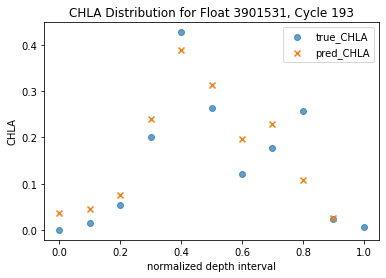

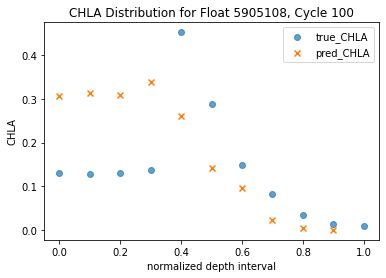

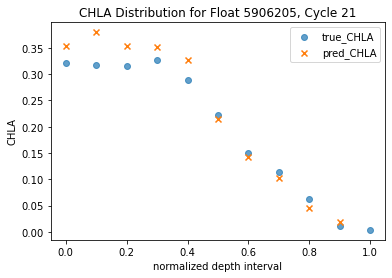

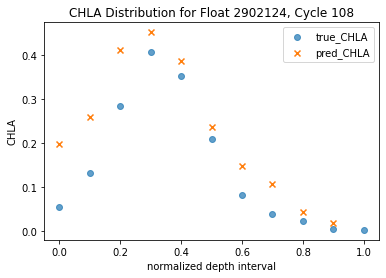

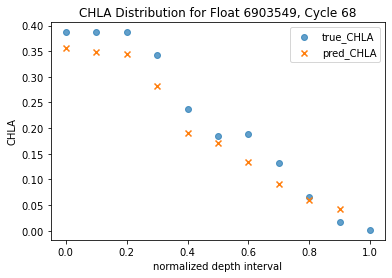

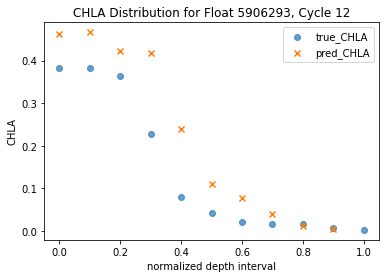

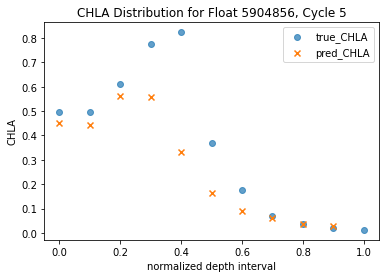

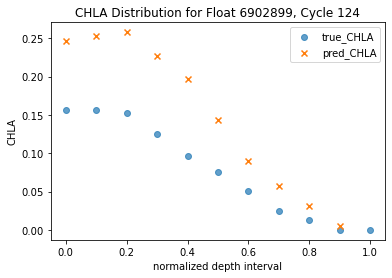

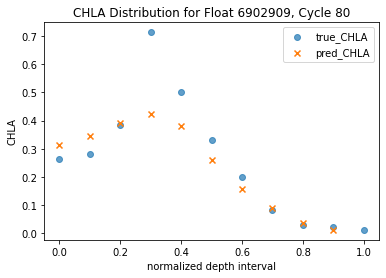

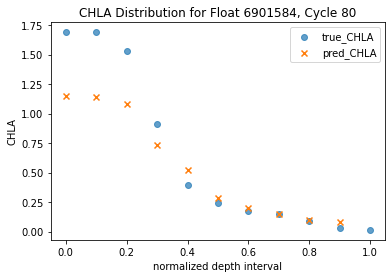

In [26]:
num = 10
for i in range(num):
    # choose a random float-cycle from the test data
    f = random.choice(test_df['float'])
    float_df = test_df[test_df['float']==f]
    c = random.choice(np.unique(float_df['cycle']))
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'input_depth': np.arange(0,1,0.1)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)
    
    for idx, p in enumerate(preds):
        if p < 0:
            preds[idx] = 0

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['norm'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true_CHLA')
    plt.scatter(feats_df['input_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()


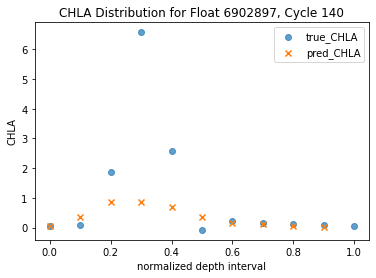

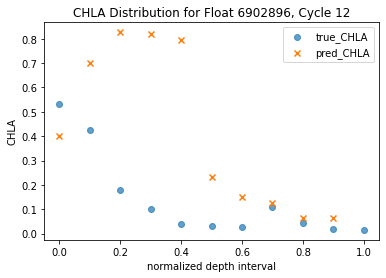

In [27]:
# repeat with some known unusual cycles with missed peaks, for example
unusual_float_cycles = [(6902897, 140), (6902896, 12)]
for i in range(len(unusual_float_cycles)):
    # choose a random float-cycle from the test data
    f, c = unusual_float_cycles[i]
    float_df = test_df[test_df['float']==f]
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'input_depth': np.arange(0,1,0.1)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)
    
    for idx, p in enumerate(preds):
        if p < 0:
            preds[idx] = 0

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['norm'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true_CHLA')
    plt.scatter(feats_df['input_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()